In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm
import os
import argparse
import re
import torch

In [2]:
data_dir = Path('../')
if not os.path.exists("./data"):
    os.mkdir("./data")

def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type':'category' , 'source':'str'}
        ).assign(id=path.stem)
        .rename_axis('cell_id')
    )

In [4]:
paths_train = list((data_dir / 'train').glob('*.json'))[:500]

notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train , desc='Train notebooks')
]

df = (
    pd.concat(notebooks_train)
        .set_index('id' , append=True)
        .swaplevel()
        .sort_index(level='id' , sort_remaining=False)
)
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True
).str.split()

def get_ranks(base , derived):
    return [base.index(d) for d in derived]

df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right'
)

ranks = {}
for id_ , cell_order , cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id':cell_id , 'rank':get_ranks(cell_order , cell_id)}
df_ranks = (
    pd.DataFrame.from_dict(ranks , orient='index')
        .rename_axis('id')
        .apply(pd.Series.explode)
        .set_index('cell_id' , append=True)
)


df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

df

Train notebooks: 100%|██████████| 500/500 [00:01<00:00, 286.80it/s]


,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,00001756c60be8,1862f0a6,code,# This Python 3 environment comes with many he...,0,945aea18,NaN,0.0
1,00001756c60be8,2a9e43d6,code,import numpy as np\nimport pandas as pd\nimpor...,2,945aea18,NaN,0.034483
2,00001756c60be8,038b763d,code,import warnings\nwarnings.filterwarnings('igno...,4,945aea18,NaN,0.068966
3,00001756c60be8,2eefe0ef,code,matplotlib.rcParams.update({'font.size': 14}),6,945aea18,NaN,0.103448
4,00001756c60be8,0beab1cd,code,"def evaluate_preds(train_true_values, train_pr...",8,945aea18,NaN,0.137931
...,...,...,...,...,...,...,...,...
23462,00f336f108d256,63540369,markdown,This datafield has no missing values or issues.,71,6bb2f11e,NaN,0.596639
23463,00f336f108d256,7e9c02da,markdown,#### Heart Disease,88,6bb2f11e,NaN,0.739496
23464,00f336f108d256,132cf4a9,markdown,There doesnt appear to be any issues with the ...,14,6bb2f11e,NaN,0.117647
23465,00f336f108d256,e6053ba0,markdown,The value has been imputed with the mean from ...,35,6bb2f11e,NaN,0.294118


In [6]:
# 代码清洗
def clean_code(cell):
    cleaned_code = re.sub(r"^#.*\n" , " " , str(cell) , flags=re.MULTILINE) #第一次去除 #类注释
    cleaned_code = re.sub(r'""".+"""', ' ', cleaned_code) # 去除 “”“”“”类型注释
    cleaned_code = re.sub(r' +', ' ', cleaned_code) # 去除多个空格那类型
    cleaned_code.replace("\\n" , " ")
    cleaned_code = cleaned_code.replace("\n" , " ") # 去除换行符
    return cleaned_code

In [11]:
codes_len = []
for idx , sub_df in tqdm(df.groupby("id")):
    code_sub_df = sub_df[sub_df["cell_type"] == "code"]
    codes_len.append(len(code_sub_df))
codes_len

100%|██████████| 500/500 [00:00<00:00, 3204.40it/s]


[30,
 72,
 11,
 178,
 8,
 23,
 8,
 17,
 19,
 28,
 25,
 10,
 22,
 79,
 89,
 26,
 10,
 38,
 13,
 9,
 30,
 24,
 49,
 46,
 112,
 25,
 20,
 49,
 37,
 24,
 47,
 16,
 13,
 70,
 25,
 60,
 12,
 32,
 33,
 14,
 35,
 49,
 56,
 18,
 7,
 18,
 28,
 114,
 14,
 20,
 23,
 66,
 8,
 14,
 25,
 17,
 44,
 16,
 43,
 15,
 34,
 26,
 13,
 8,
 25,
 42,
 21,
 21,
 41,
 16,
 29,
 25,
 9,
 13,
 21,
 59,
 11,
 10,
 34,
 23,
 8,
 13,
 27,
 3,
 19,
 7,
 12,
 26,
 5,
 27,
 22,
 19,
 10,
 8,
 28,
 40,
 111,
 64,
 15,
 18,
 73,
 48,
 25,
 145,
 37,
 75,
 47,
 13,
 8,
 44,
 29,
 10,
 16,
 4,
 15,
 28,
 58,
 32,
 24,
 38,
 23,
 17,
 84,
 51,
 36,
 82,
 41,
 48,
 11,
 29,
 22,
 5,
 20,
 82,
 24,
 15,
 18,
 63,
 58,
 43,
 59,
 74,
 11,
 30,
 19,
 39,
 16,
 13,
 15,
 47,
 6,
 18,
 44,
 30,
 7,
 6,
 6,
 8,
 134,
 26,
 29,
 19,
 4,
 10,
 56,
 20,
 17,
 16,
 52,
 20,
 6,
 31,
 28,
 53,
 57,
 11,
 18,
 29,
 8,
 21,
 7,
 11,
 9,
 51,
 30,
 19,
 40,
 22,
 17,
 59,
 22,
 69,
 17,
 56,
 14,
 46,
 23,
 44,
 48,
 46,
 33,
 17,
 30,
 7,


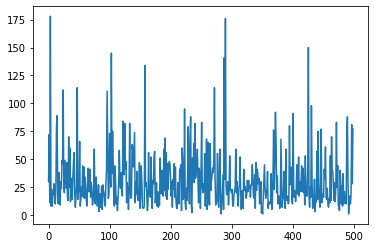

In [13]:
from matplotlib import pyplot as plt
plt.plot(codes_len)

有的数据还是挺多的，看起来。 也正因如此需要对一些数据做一定的压缩处理，等距截断